In [1]:
import numpy as np
from tqdm import tqdm
import os
import shutil
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms as T

from networks.unet import Unet

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset

In [3]:
data_path = "/home/son/Desktop/Research/YOLO_ATTACK_GRAD/data/son_result/coco2017_yolov8m.pt_0.55_numobject_0_3000"
full_data = os.path.join(data_path, "images_full", 'val')

clean_imgs_path = os.path.join(data_path, 'clean', 'images')
noise_imgs_path = os.path.join(data_path, 'noise', 'images')
os.makedirs(clean_imgs_path, exist_ok = True)
os.makedirs(noise_imgs_path, exist_ok = True)

In [23]:
for img_name in sorted(os.listdir(full_data)):
    img_real_path = os.path.join(full_data, img_name)
    imgs = img_name.split('_')
    if len(imgs) == 2:  #base img
        img_base_path = os.path.join(clean_imgs_path, imgs[0] + '.jpg')
        shutil.copy(img_real_path, img_base_path)
    else:               #attack img
        img_attack_path = os.path.join(noise_imgs_path, imgs[0] + '.jpg')
        shutil.copy(img_real_path, img_attack_path)
print("Done!")
print("-----------------------------------------------------------------------------------------------")


Done!
-----------------------------------------------------------------------------------------------


In [4]:
noise_folder = '/home/son/Desktop/Research/YOLO_ATTACK_GRAD/data/son_result/coco2017_yolov8m.pt_0.55_numobject_0_3000/noise'
noise_image_folder = os.path.join(noise_folder, 'images')
noise_label_folder = os.path.join(noise_folder, 'labels')

noise_image_filenames = sorted(os.listdir(noise_image_folder))
noise_label_filenames = sorted(os.listdir(noise_label_folder))

noise_label_filename = noise_label_filenames[0]
noise_label_path = os.path.join(noise_label_folder, noise_label_filename)

f = open(noise_label_path, 'r')
xyxy = []
for line in f.readlines():
    x1, y1, x2, y2 = map(float, line.strip().split()[:4])
    xyxy.append([x1, y1, x2, y2])
xyxy

[[514.324, 270.987, 530.541, 308.606],
 [588.792, 269.203, 601.246, 289.871],
 [376.182, 263.241, 409.537, 287.935],
 [546.149, 249.544, 554.678, 263.212],
 [603.852, 271.702, 613.771, 283.526],
 [447.693, 280.483, 488.466, 306.43]]

In [5]:
# Custom Dataset class
class NoiseGenerationDataset(Dataset):
    def __init__(self, base_image_folder, noise_folder, transform=None):
        self.base_image_folder = os.path.join(base_image_folder, 'images')
        self.noise_image_folder = os.path.join(noise_folder, 'images')
        self.noise_label_folder = os.path.join(noise_folder, 'labels')
        self.transform = transform
        
        # List image filenames in the folders
        self.base_image_filenames = sorted(os.listdir(self.base_image_folder))
        self.noise_image_filenames = sorted(os.listdir(self.noise_image_folder))
        self.noise_label_filenames = sorted(os.listdir(self.noise_label_folder))
    
    def __len__(self):
        return len(self.base_image_filenames)
    
    def __getitem__(self, idx):
        base_image_filename = self.base_image_filenames[idx]
        noise_image_filename = self.noise_image_filenames[idx]
        noise_label_filename = self.noise_label_filenames[idx]

        # Load base image
        base_image_path = os.path.join(self.base_image_folder, base_image_filename)
        base_image = Image.open(base_image_path).convert("RGB")
        
        # Load noise images
        noise_image_path = os.path.join(self.noise_image_folder, noise_image_filename)
        noise_image = Image.open(noise_image_path).convert("RGB")

        # Load noise label
        noise_label_path = os.path.join(self.noise_label_folder, noise_label_filename)
        f = open(noise_label_path, 'r')
        xyxy = []
        for line in f.readlines():
            x1, y1, x2, y2 = map(float, line.strip().split()[:4])
            xyxy.append([x1, y1, x2, y2])
        
        if self.transform:
            base_image = self.transform(base_image)
            noise_image = self.transform(noise_image)
        
        return base_image, noise_image, xyxy


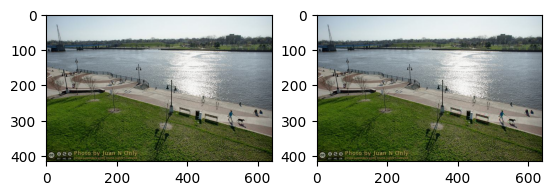

In [6]:
transforms = T.Compose([T.ToTensor(),
                        ])

# Create the dataset and DataLoader
base_image_folder = '/home/son/Desktop/Research/YOLO_ATTACK_GRAD/data/son_result/coco2017_yolov8m.pt_0.55_numobject_0_3000/clean'
noise_image_folder = '/home/son/Desktop/Research/YOLO_ATTACK_GRAD/data/son_result/coco2017_yolov8m.pt_0.55_numobject_0_3000/noise'
batch_size = 1

dataset = NoiseGenerationDataset(base_image_folder, noise_image_folder, transforms)
# dataset = NoiseGenerationDataset(base_image_folder, noise_image_folder)

# Test
clean = dataset[0][0]
noise = dataset[0][1]

f, plots = plt.subplots(1,2)
plots[0].imshow(clean.permute(1, 2, 0))
plots[1].imshow(noise.permute(1, 2, 0))

# Dataloader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [8]:
x = next(iter(dataloader))
x

[tensor([[[[0.3529, 0.3529, 0.3608,  ..., 0.2863, 0.2824, 0.2784],
           [0.3529, 0.3529, 0.3608,  ..., 0.2863, 0.2824, 0.2784],
           [0.3569, 0.3529, 0.3608,  ..., 0.2863, 0.2824, 0.2784],
           ...,
           [0.2314, 0.2314, 0.2314,  ..., 0.1961, 0.1961, 0.1961],
           [0.2235, 0.2275, 0.2314,  ..., 0.2000, 0.2078, 0.2118],
           [0.2235, 0.2275, 0.2314,  ..., 0.2000, 0.2078, 0.2118]],
 
          [[0.3255, 0.3255, 0.3333,  ..., 0.2667, 0.2627, 0.2588],
           [0.3255, 0.3255, 0.3333,  ..., 0.2667, 0.2627, 0.2588],
           [0.3294, 0.3255, 0.3333,  ..., 0.2667, 0.2627, 0.2588],
           ...,
           [0.1961, 0.1961, 0.1961,  ..., 0.1647, 0.1647, 0.1647],
           [0.1882, 0.1922, 0.1961,  ..., 0.1686, 0.1765, 0.1804],
           [0.1882, 0.1922, 0.1961,  ..., 0.1686, 0.1765, 0.1804]],
 
          [[0.2549, 0.2549, 0.2706,  ..., 0.2431, 0.2392, 0.2353],
           [0.2549, 0.2549, 0.2706,  ..., 0.2431, 0.2392, 0.2353],
           [0.2588, 0.25

In [15]:
xyxy = x[2][0]

In [16]:
xyxy

[tensor([191.0010], dtype=torch.float64),
 tensor([237.2510], dtype=torch.float64),
 tensor([284.8780], dtype=torch.float64),
 tensor([337.6230], dtype=torch.float64)]

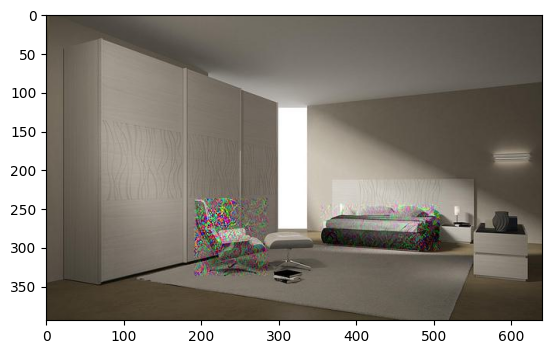

In [12]:
plt.imshow(x[1].squeeze(0).permute(1, 2, 0))

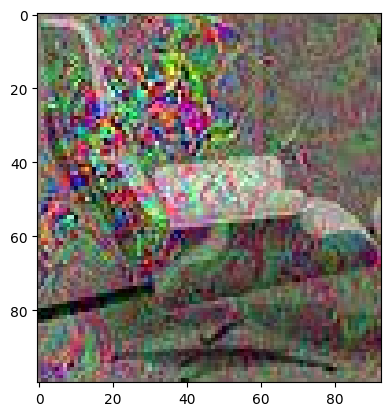

In [17]:
plt.imshow(x[1][:, :, int(xyxy[1].item()):int(xyxy[3].item()), int(xyxy[0].item()):int(xyxy[2].item())].squeeze(0).permute(1, 2, 0))

In [95]:
next(iter(dataloader))[1].size()

torch.Size([1, 3, 424, 640])

(416, 640, 3)


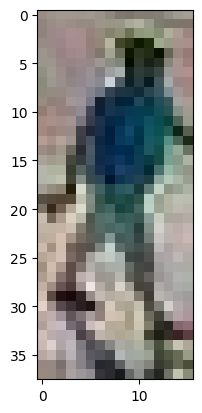

In [83]:
img = cv2.imread('/home/son/Desktop/Research/YOLO_ATTACK_GRAD/data/son_result/coco2017_yolov8m.pt_0.55_numobject_0_3000/noise/images/000000000109.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print(img.shape)
plt.imshow(img[270:308, 514:530])

# Model

In [7]:
model_name = "Unet"

model = Unet (
       in_chans = 3,  #Number of channels in the input to the U-Net model
       out_chans = 3, #Number of channels in the output to the U-Net model
       chans = 21,    #Number of output channels of the first convolution layer
).cuda()

In [8]:
max_epoch = 1501
lr = 0.005
decay_step = 500
decay_gamma = 0.5
iterations=[0,10,50,100,700,1100,1500]

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=decay_step, gamma=decay_gamma)

In [9]:
model.train()

for epoch in range(max_epoch):
    total_loss = 0.0
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{max_epoch}", leave=False)
    
    for base_image, noise_image, xyxys in progress_bar:
        # plt.imshow(base_image.squeeze().permute(1, 2, 0))
        # plt.show()
        base_image = base_image.to(device)
        noise_image = noise_image.to(device)
        optimizer.zero_grad()
        
        # Generate noise images using the U-Net
        predicted_noise = model(base_image)

        mask_box = torch.zeros_like(predicted_noise)

        if len(xyxys)> 0:
            for i in range(len(xyxys)):
                x1 = int(xyxys[i][1].item())
                x2 = int(xyxys[i][3].item())
                y1 = int(xyxys[i][0].item())
                y2 = int(xyxys[i][2].item())

                mask_box[:, :, x1:x2, y1:y2] = 1
        
        predicted_noise = predicted_noise * mask_box
        label_noise = noise_image * mask_box
        # print(predicted_noise.size())
        # plt.imshow(label_noise.squeeze().detach().cpu().permute(1, 2, 0))
        # plt.show()
        # break
        loss = criterion(predicted_noise, label_noise)

        loss.backward()
        optimizer.step()
    
        total_loss += loss.item()
        
        # Update the tqdm progress bar
        progress_bar.set_postfix({"Loss": loss.item()})
    
    average_loss = total_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{max_epoch}], Average Loss: {average_loss:.4f}")

Epoch [1/1501], Average Loss: 0.0163


Epoch [2/1501], Average Loss: 0.0138


Epoch [3/1501], Average Loss: 0.0133


KeyboardInterrupt: 

In [10]:
img_path = '/home/son/Desktop/Research/YOLO_ATTACK_GRAD/unet/callisto/coco2017_yolov8l.pt_0.5_ncc_0.75_667-2501/clean/000000000139.jpg'
test_img = Image.open(img_path).convert("RGB")
transforms = T.Compose([T.ToTensor(),
                        ])
test_img = transforms(test_img)
test_img.shape

torch.Size([3, 426, 640])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


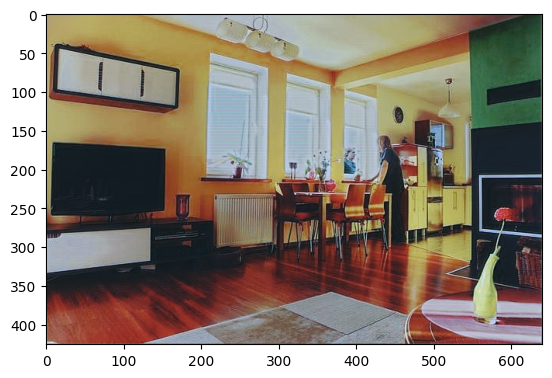

In [15]:
pred = model(test_img.to(device).unsqueeze(0)).squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
plt.imshow(pred)

In [76]:
test_img.permute(1, 2, 0).shape

torch.Size([256, 256, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


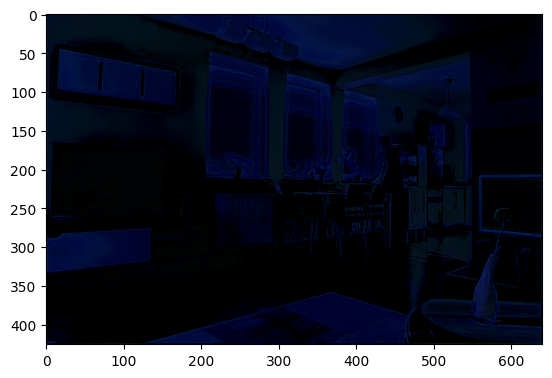

In [16]:
diff = (pred - test_img.permute(1, 2, 0).numpy())
plt.imshow(diff)

In [12]:
#train
def train(model, optimizer, clean_img, noisy_img):
    model.train()
    
    # reset optimizer's gradient
    optimizer.zero_grad()
    
    # get the prediction
    pred_noise = model(clean_img.unsqueeze(0)).squeeze(0)
    # print(pred_noise.shape)
    
    loss = criterion(pred_noise, noisy_img)
    # print(loss)
    loss.backward()
    optimizer.step()

    return loss.item()

In [13]:
losses = []
generated_noise = []

for i in tqdm(range(max_epoch)):
    
    loss = train(model, optimizer, clean_img, noisy_img)
    losses.append(loss)

    scheduler.step()
    
    with torch.no_grad(): 
        if i in iterations:
            generated_noise.append(model(clean_img.unsqueeze(0)).squeeze(0))

    if i%50 == 0:
        print(i, loss, end='\r')

  0%|          | 1/1501 [00:00<10:03,  2.49it/s]

  3%|▎         | 52/1501 [00:13<05:08,  4.69it/s]

  7%|▋         | 102/1501 [00:25<04:49,  4.82it/s]

 10%|█         | 151/1501 [00:36<05:01,  4.48it/s]

 12%|█▏        | 184/1501 [00:45<05:25,  4.04it/s]


KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


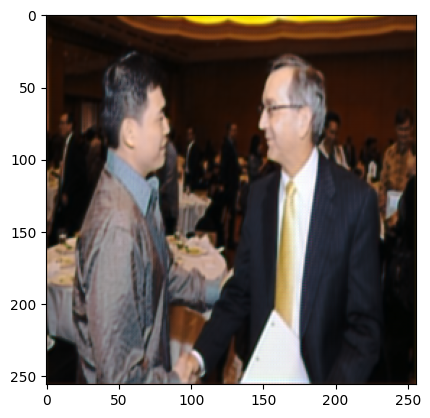

In [14]:
out = model(clean_img.unsqueeze(0)).squeeze(0).permute(1, 2, 0).detach().numpy()
plt.imshow(out)

(256, 256, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


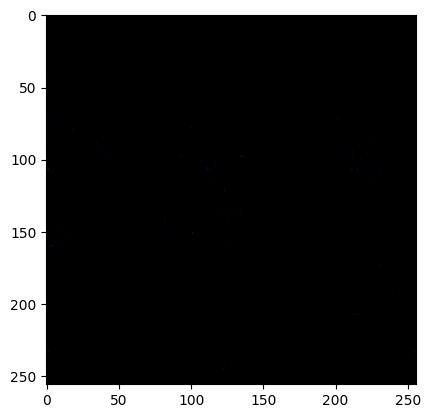

In [19]:
clean_img = cv2.imread('./base.jpg')
clean_img = cv2.cvtColor(clean_img, cv2.COLOR_BGR2RGB)
clean_img = cv2.resize(clean_img, (256, 256))

new_img = out - clean_img
plt.imshow(new_img, cmap='gray')

In [18]:
new_img

array([[[-14.759416 ,  -9.866534 ,  -6.899238 ],
        [-15.831928 , -10.890663 ,  -7.915272 ],
        [-17.83845  , -12.896479 ,  -9.928313 ],
        ...,
        [-86.62139  , -42.80326  , -15.912874 ],
        [-83.6531   , -39.813267 , -12.921884 ],
        [-80.60851  , -36.817505 ,  -9.91181  ]],

       [[-17.840628 , -12.884477 ,  -9.903234 ],
        [-16.892715 , -11.913036 ,  -8.9418125],
        [-15.902642 , -10.9269   ,  -7.946777 ],
        ...,
        [-79.679184 , -35.827065 , -10.938218 ],
        [-77.728325 , -33.84654  ,  -8.928718 ],
        [-76.67089  , -33.809174 ,  -8.930754 ]],

       [[-16.863592 , -11.89774  ,  -8.9149065],
        [-17.913298 , -12.930835 ,  -9.961335 ],
        [-18.925955 , -13.94926  , -10.964973 ],
        ...,
        [-83.6693   , -39.850616 , -14.945618 ],
        [-83.69983  , -39.85106  , -14.937874 ],
        [-84.67329  , -39.82785  , -14.932322 ]],

       ...,

       [[ -6.867197 ,  -6.9043007,  -6.923395 ],
        [ -